In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from cuml.svm import SVC as cuSVC

In [6]:
df = pd.read_csv("cleaned_data.csv", encoding='latin-1')
df.head()

,target,ids,date,flag,user,text,cleaned_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda get david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,dive many time ball manage save rest go bound
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",behave mad see


In [7]:
df.dropna(inplace=True)
df.isna().sum()

target          0
ids             0
date            0
flag            0
user            0
text            0
cleaned_text    0
dtype: int64

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',
                             ngram_range=(1,3), max_df=0.75,
                             min_df=1, use_idf=True,
                             smooth_idf=True, max_features=5000)

# Fit and transform
X_tfidf  = tfidf_vectorizer.fit_transform(df['cleaned_text'])


In [5]:
len(feature_names)

5000

In [9]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf,df['target'],stratify=df['target'],random_state=42)


In [7]:
clf = cuSVC(C=1.0, kernel='rbf', gamma='scale', probability=False, random_state=42)
clf.fit(X_train_tfidf.astype('float32'), y_train)

y_pred = clf.predict(X_test_tfidf.astype('float32'))

In [5]:
print('Train_Set_Size:'+str(X_train_tfidf.shape))
print('Test_Set_Size:'+str(X_test_tfidf.shape))

Train_Set_Size:(1193413, 5000)
Test_Set_Size:(397805, 5000)


In [7]:
clf = cuSVC(C=1.0, kernel='rbf', gamma='scale', probability=False, random_state=42)
clf.fit(X_train_tfidf.astype('float32'), y_train)

y_pred = clf.predict(X_test_tfidf.astype('float32'))

In [10]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.72      0.75    198949
           4       0.74      0.80      0.77    198856

    accuracy                           0.76    397805
   macro avg       0.76      0.76      0.76    397805
weighted avg       0.76      0.76      0.76    397805



In [13]:
param_grid = {
    'C': [0.1, 1],
    'kernel': ['rbf', 'linear'],
}

In [19]:
best_score = -1
best_params = None
best_model = None

for C in param_grid['C']:
    for kernel in param_grid['kernel']:
        params = {'C': C, 'kernel': kernel}
        print(f"Testing parameters: {params}")
        
        model = CuSVC(C=C, kernel=kernel)
        
        try:
            scores = cross_val_score(model, X_train_tfidf.astype(np.float32), y_train, cv=3, n_jobs=2)  # Reduced n_jobs
            mean_score = scores.mean()
            print(f"Mean cross-validation score: {mean_score}")
            
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
                best_model = model
        except Exception as e:
            print(f"An error occurred: {e}")

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

if best_model:
    best_model.fit(X_train_tfidf.astype(np.float32), y_train)

    accuracy = best_model.score(X_test_tfidf.astype(np.float32), y_test)
    print("Test Set Accuracy:", accuracy)

    with open('best_model.pkl', 'wb') as file:
        pickle.dump(best_svc_tfidf, file)
else:
    print("No valid model found.")


Testing parameters: {'C': 0.1, 'kernel': 'rbf'}
Mean cross-validation score: 0.7507099509239197
Testing parameters: {'C': 0.1, 'kernel': 'linear'}
[W] [20:03:40.474669] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.
Mean cross-validation score: 0.7507535219192505
Testing parameters: {'C': 1, 'kernel': 'rbf'}
Mean cross-validation score: 0.7593247294425964
Testing parameters: {'C': 1, 'kernel': 'linear'}
Mean cross-validation score: 0.750714123249054
Best Parameters: {'C': 1, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.7593247294425964
Test Set Accuracy: 0.7612699866294861


In [12]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76    198949
           4       0.75      0.81      0.77    198856

    accuracy                           0.77    397805
   macro avg       0.77      0.77      0.77    397805
weighted avg       0.77      0.77      0.77    397805



In [1]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[145232  38606]
 [ 37782 160342]]


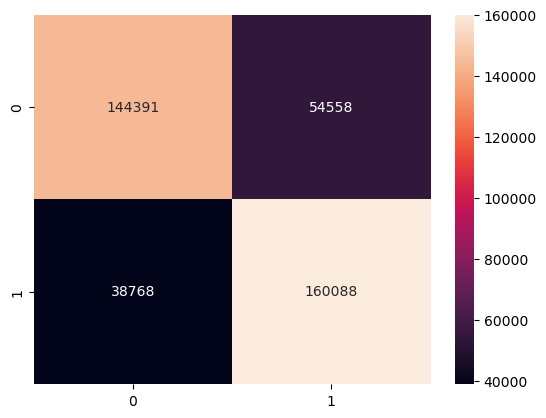

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d')
plt.show()